In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df=pd.read_excel("One District One Product.xlsx")

In [3]:
print("Shape of dataset:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nSample Data:\n", df.head())
print("\nDescription of Dataset:\n", df.describe())
print("\nInformation of Dataset:\n",df.info)

Shape of dataset: (1241, 10)

Data Types:
 State                   object
Product                 object
District                object
LGD Code                 int64
Category                object
Sector                  object
Description             object
GI Status               object
Photo                   object
Ministry/ Department    object
dtype: object

Missing Values:
 State                   0
Product                 0
District                0
LGD Code                0
Category                0
Sector                  0
Description             0
GI Status               0
Photo                   0
Ministry/ Department    0
dtype: int64

Sample Data:
                          State                           Product  \
0  Andaman and Nicobar Islands  Coconut & Coconut based products   
1  Andaman and Nicobar Islands         Fisheries/Marine products   
2  Andaman and Nicobar Islands                   Marine Products   
3               Andhra Pradesh                    Coffe

In [4]:
df_clean = df.drop(columns=["LGD Code", "Photo"])
df_clean

,State,Product,District,Category,Sector,Description,GI Status,Ministry/ Department
0,Andaman and Nicobar Islands,Coconut & Coconut based products,Nicobars,Primary,Agriculture,The Nicobar Islands are known for their abunda...,No,Ministry of Agriculture & Farmers' Welfare
1,Andaman and Nicobar Islands,Fisheries/Marine products,North and Middle Andaman,Primary,Marine,"The North and Middle Andaman islands, are know...",No,Department of Fisheries
2,Andaman and Nicobar Islands,Marine Products,South Andamans,Primary,Marine,"A delight for seafood enthusiasts, South Andam...",No,Department of Fisheries
3,Andhra Pradesh,Coffee (Araku),Alluri Sitarama Raju,Primary,Agriculture,Andhra Pradesh is one of the major coffee prod...,Yes,Ministry of Agriculture & Farmers' Welfare
4,Andhra Pradesh,Bamboo Craft,Alluri Sitarama Raju,Secondary,Handicraft,Crafted with finesse in Andhra Pradesh's Allur...,No,DC Handicraft
...,...,...,...,...,...,...,...,...
1236,West Bengal,Leather Goods,South 24 Parganas,Primary,Handicraft,These goods from South 24 Parganas are made us...,No,DC Handicraft
1237,West Bengal,Marine Products,South 24 Parganas,Secondary,Marine,Marine products from this region are products ...,No,Department of fisheries
1238,West Bengal,Sundarban Honey,South 24 Parganas,Tertiary,Agriculture,Sundarban honey is considered to be one of the...,Yes,Ministry of Agriculture & Farmers' Welfare
1239,West Bengal,Tulai Panji Rice (Aromatic Rice),Uttar Dinajpur (North Dinajpur),Primary,Agriculture,"Uttar Dinajpur is known for the Tulai Panji, a...",Yes,Ministry of Agriculture & Farmers' Welfare


In [5]:
df_clean['GI Status'] = df_clean['GI Status'].str.strip().str.lower().map({
    'yes': 'Yes',
    'no': 'No'
})

# Confirm the changes
print(df_clean['GI Status'].value_counts())

GI Status
No     985
Yes    256
Name: count, dtype: int64


In [6]:
df_clean['Category'] = df_clean['Category'].str.strip().str.lower().map({
    'primary': 'Primary',
    'secondary': 'Secondary',
    'tertiary': 'Tertiary'
})

# Confirm the changes
print(df_clean['Category'].value_counts())

Category
Primary      776
Secondary    314
Tertiary     103
Name: count, dtype: int64


In [7]:
df_clean['Sector'].value_counts()

Sector
Agriculture        418
Handicraft         251
Manufacturing      173
Food Processing    115
Textile            103
Handloom           100
Marine              32
Others              29
Dairy                9
Food processing      7
dairy                1
textile              1
handicraft           1
handlooms            1
Name: count, dtype: int64

In [8]:
# Clean and map sector names
df_clean['Sector_clean'] = df_clean['Sector'].str.strip().str.lower()
sector_mapping = {
    'handicraft': 'Handicraft',
    'dairy': 'Dairy',
    'food processing': 'Food Processing',
    'textile': 'Textile',
    'handlooms': 'Handloom',
    'handloom': 'Handloom'
}

df_clean['Sector_clean'] = df_clean['Sector_clean'].map(sector_mapping).fillna(df_clean['Sector'])
print(df_clean['Sector_clean'].value_counts())

Sector_clean
Agriculture        418
Handicraft         252
Manufacturing      173
Food Processing    122
Textile            104
Handloom           101
Marine              32
Others              29
Dairy               10
Name: count, dtype: int64


In [9]:
df_clean['Sector_clean'].unique()

array(['Agriculture', 'Marine', 'Handicraft', 'Food Processing',
       'Handloom', 'Textile', 'Manufacturing', 'Others', 'Dairy'],
      dtype=object)

In [10]:
# Count how many products are listed for each district
district_counts = df_clean['District'].value_counts()
district_counts.sample(10)

District
West Khasi Hills      2
Mansa                 2
Agra                  2
Murshidabad           2
East Jaintia Hills    1
Latehar               1
Bemetara              1
Bharatpur             1
Krishna               5
Ariyalur              1
Name: count, dtype: int64

In [11]:
# Map those counts back to the original DataFrame
df_clean['District Product Count'] = df_clean['District'].map(district_counts)
df_clean.head()

,State,Product,District,Category,Sector,Description,GI Status,Ministry/ Department,Sector_clean,District Product Count
0,Andaman and Nicobar Islands,Coconut & Coconut based products,Nicobars,Primary,Agriculture,The Nicobar Islands are known for their abunda...,No,Ministry of Agriculture & Farmers' Welfare,Agriculture,1
1,Andaman and Nicobar Islands,Fisheries/Marine products,North and Middle Andaman,Primary,Marine,"The North and Middle Andaman islands, are know...",No,Department of Fisheries,Marine,1
2,Andaman and Nicobar Islands,Marine Products,South Andamans,Primary,Marine,"A delight for seafood enthusiasts, South Andam...",No,Department of Fisheries,Marine,1
3,Andhra Pradesh,Coffee (Araku),Alluri Sitarama Raju,Primary,Agriculture,Andhra Pradesh is one of the major coffee prod...,Yes,Ministry of Agriculture & Farmers' Welfare,Agriculture,3
4,Andhra Pradesh,Bamboo Craft,Alluri Sitarama Raju,Secondary,Handicraft,Crafted with finesse in Andhra Pradesh's Allur...,No,DC Handicraft,Handicraft,3


In [12]:
#UNIVARIATE ANALYSIS

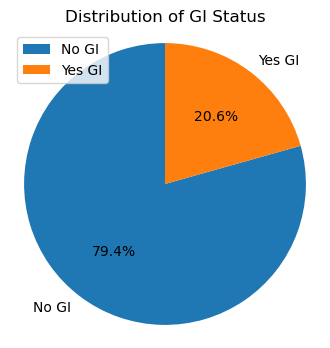

In [13]:
# Count of each GI Status
gi_counts = df_clean['GI Status'].value_counts()

plt.figure(figsize=(4,4))
plt.pie(gi_counts, labels=['No GI', 'Yes GI'], autopct='%1.1f%%', startangle=90)
plt.legend(loc="upper left")
plt.title("Distribution of GI Status")
plt.axis('equal')
plt.show()

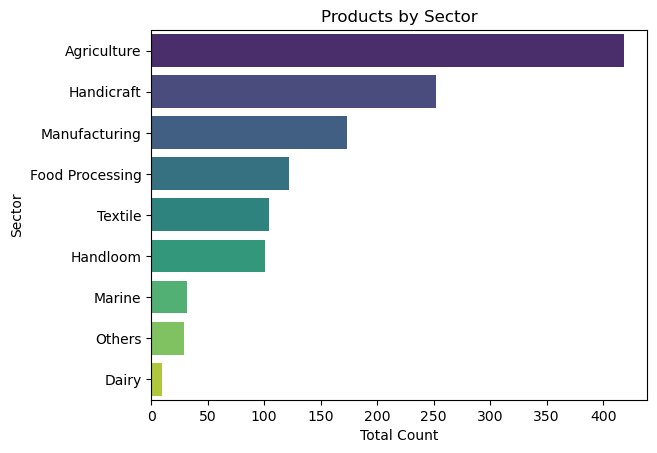

Sector_clean
Agriculture        418
Handicraft         252
Manufacturing      173
Food Processing    122
Textile            104
Handloom           101
Marine              32
Others              29
Dairy               10
Name: count, dtype: int64


In [14]:
# Sector
sector_counts = df_clean['Sector_clean'].value_counts()
sns.barplot(x=sector_counts.values, y=sector_counts.index,hue=sector_counts.index,palette="viridis")
plt.title("Products by Sector")
plt.xlabel("Total Count")
plt.ylabel("Sector")
plt.show()

print(df_clean['Sector_clean'].value_counts())

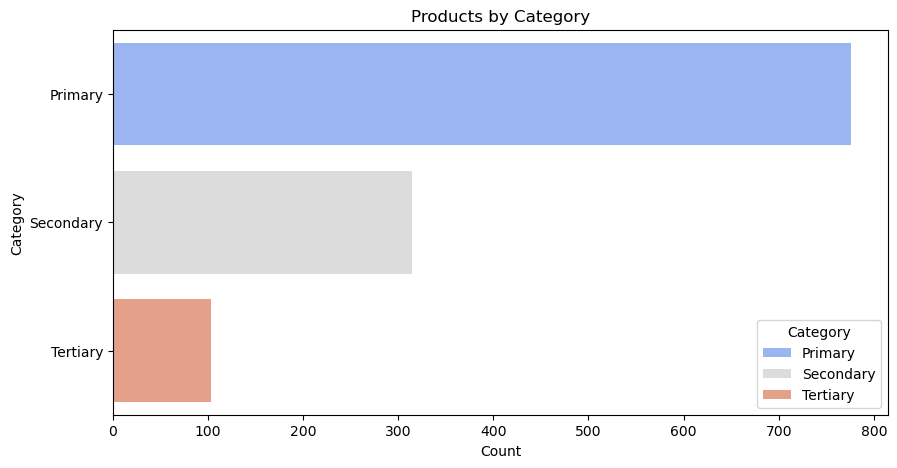

Category
Primary      776
Secondary    314
Tertiary     103
Name: count, dtype: int64


In [15]:
# Category
plt.figure(figsize=(10,5))
sns.countplot(y=df_clean['Category'], order=df_clean['Category'].value_counts().index, hue=df_clean['Category'], palette="coolwarm")
plt.title("Products by Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

print(df_clean['Category'].value_counts())

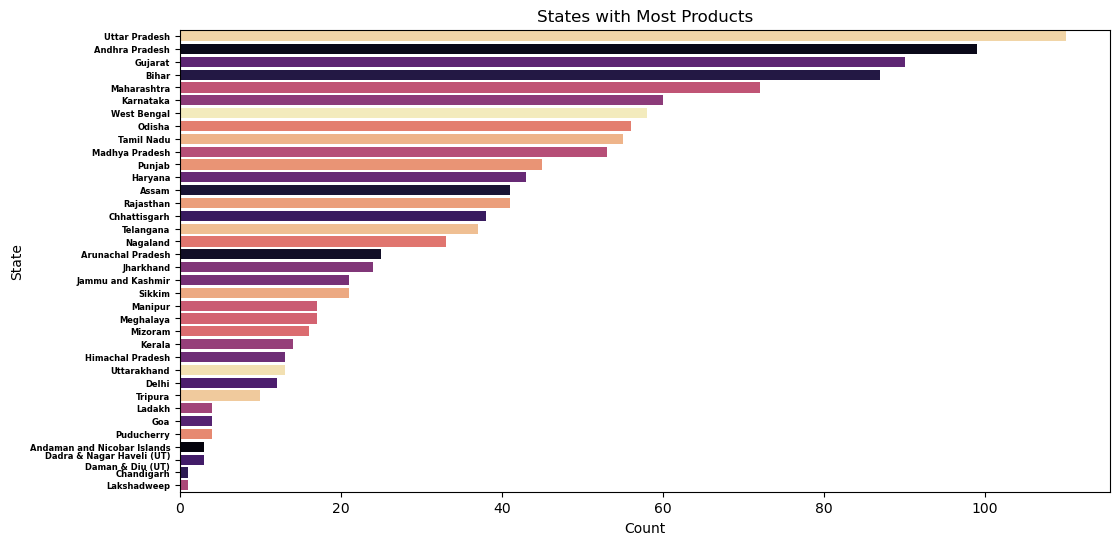

<Figure size 1200x1400 with 0 Axes>

State
Uttar Pradesh                                  110
Andhra Pradesh                                  99
Gujarat                                         90
Bihar                                           87
Maharashtra                                     72
Karnataka                                       60
West Bengal                                     58
Odisha                                          56
Tamil Nadu                                      55
Madhya Pradesh                                  53
Punjab                                          45
Haryana                                         43
Assam                                           41
Rajasthan                                       41
Chhattisgarh                                    38
Telangana                                       37
Nagaland                                        33
Arunachal Pradesh                               25
Jharkhand                                       24
Jammu and Kashmir        

In [16]:
# State
plt.figure(figsize=(12,6))
sns.countplot(y=df_clean['State'], order=df_clean['State'].value_counts().index, hue=df_clean['State'], palette="magma")
plt.title("States with Most Products")
plt.yticks(rotation=0,fontsize=6,fontweight='bold')
plt.xlabel("Count")
plt.ylabel("State")
plt.figure(figsize=(12, 14))
plt.tight_layout()
plt.show()

print(df_clean['State'].value_counts())

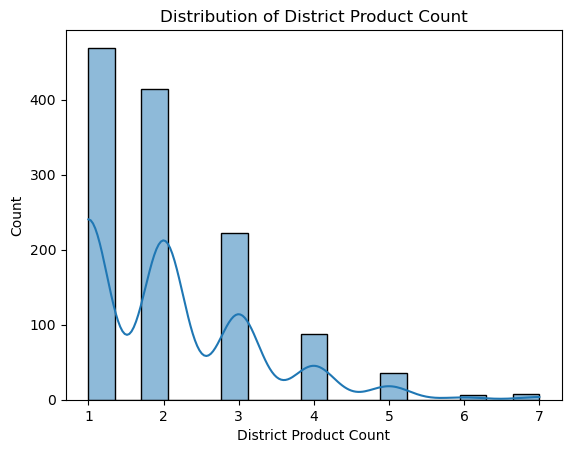

District Product Count
1    469
2    414
3    222
4     88
5     35
7      7
6      6
Name: count, dtype: int64


In [17]:
sns.histplot(df_clean['District Product Count'], kde=True)
plt.title("Distribution of District Product Count")
plt.show()

print(df_clean['District Product Count'].value_counts())

In [18]:
#BIVARIATE ANALYSIS

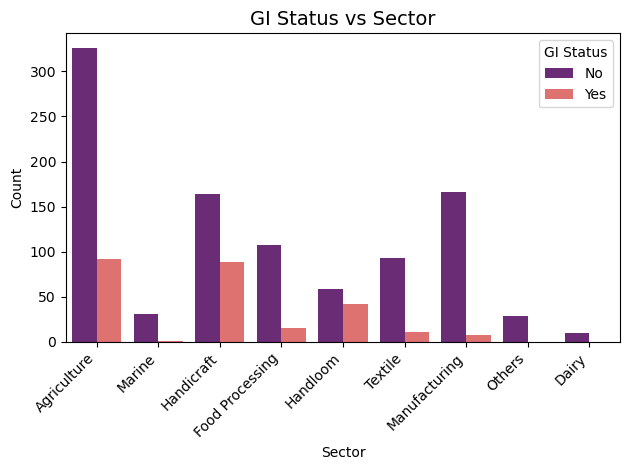

GI Status         No  Yes
Sector_clean             
Agriculture      326   92
Dairy             10    0
Food Processing  107   15
Handicraft       164   88
Handloom          59   42
Manufacturing    166    7
Marine            31    1
Others            29    0
Textile           93   11


In [19]:
#GI Status vs Sector
sns.countplot(data=df_clean, x='Sector_clean', hue='GI Status', palette='magma')
plt.title("GI Status vs Sector", fontsize=14)
plt.xlabel("Sector")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title='GI Status', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

print(pd.crosstab(df_clean['Sector_clean'],df_clean['GI Status']))

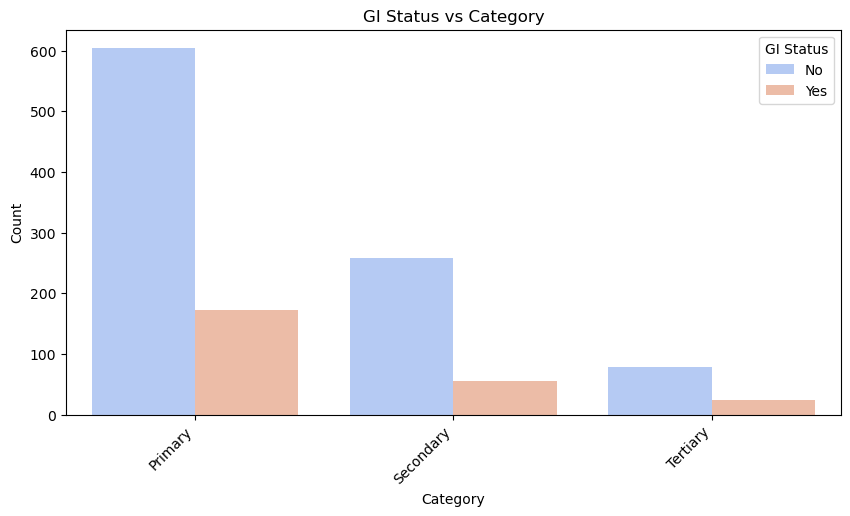

GI Status   No  Yes
Category           
Primary    604  172
Secondary  258   56
Tertiary    79   24


In [20]:
#GI Status vs Category
plt.figure(figsize=(10,5))
sns.countplot(data=df_clean, x='Category', hue='GI Status', palette="coolwarm")
plt.title("GI Status vs Category")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.show()

print(pd.crosstab(df_clean['Category'],df_clean['GI Status']))

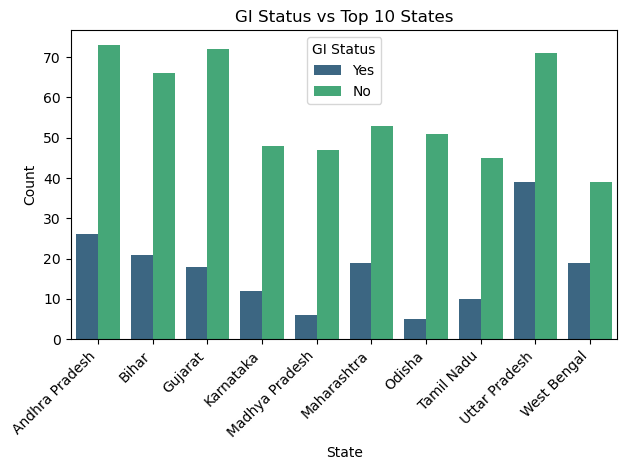

In [21]:
#Top 10 Sates
top_states = df_clean['State'].value_counts().head(10).index
sns.countplot(data=df_clean[df_clean['State'].isin(top_states)], x='State', hue='GI Status', palette="viridis")
plt.title("GI Status vs Top 10 States")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

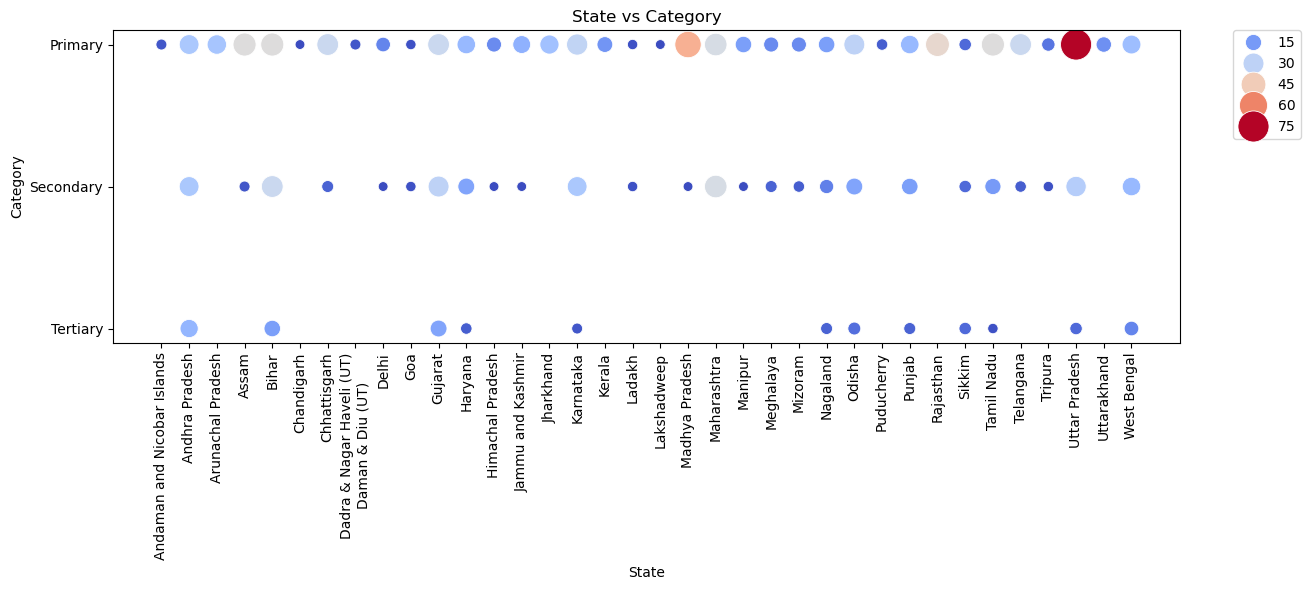

In [22]:
#State vs Category 
grouped = df_clean.groupby(['State', 'Category']).size().reset_index(name='Count')

plt.figure(figsize=(12,6))
sns.scatterplot(data=grouped, x='State', y='Category', size='Count', sizes=(50, 500), hue='Count', palette='coolwarm')
plt.title("State vs Category")
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1),borderaxespad=0)
plt.show()

In [23]:
#MULTIVARIATE ANALYSIS

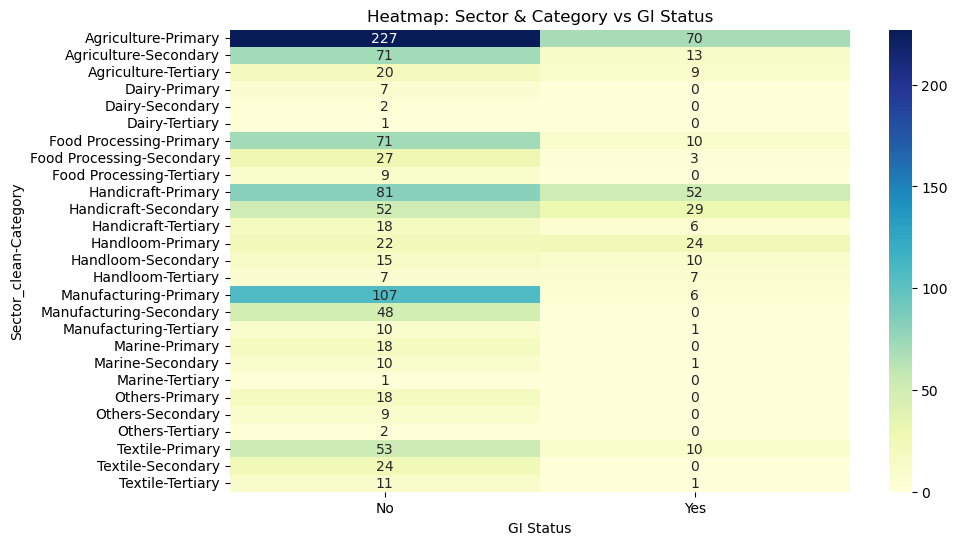

In [24]:
#Heatmap: Relationship between Sector, Category, and GI Status
plt.figure(figsize=(10,6))
cross_tab = pd.crosstab([df_clean['Sector_clean'], df_clean['Category']], df_clean['GI Status'])
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Heatmap: Sector & Category vs GI Status")
plt.show()

In [25]:
#MODELS

In [26]:
# Text preprocessing function
def preprocess_text(text):
    text = str(text).lower().strip()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Clean and combine text features
df_clean['Product_clean'] = df_clean['Product'].apply(preprocess_text)
df_clean['Combined_Text'] = df_clean['Product_clean'] + " " + df_clean['Sector_clean'] + " " + df_clean['Category']

In [27]:
# Drop rows with missing GI Status
df_clean = df_clean[df_clean['GI Status'].notna()]

# Features and target
X_text = df_clean['Combined_Text'].astype(str)
y = df_clean['GI Status'].map({'Yes': 1, 'No': 0})

In [28]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X_text)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)


In [29]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# XGBoost
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6,
                           eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)
svm_model.fit(X_train, y_train)

# Models dictionary
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "KNN": knn_model,
    "SVM": svm_model
}


In [30]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")


--- Logistic Regression ---
Accuracy: 0.7590361445783133
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84       193
           1       0.47      0.62      0.54        56

    accuracy                           0.76       249
   macro avg       0.68      0.71      0.69       249
weighted avg       0.79      0.76      0.77       249

Confusion Matrix:
 [[154  39]
 [ 21  35]]


--- Random Forest ---
Accuracy: 0.8112449799196787
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88       193
           1       0.61      0.45      0.52        56

    accuracy                           0.81       249
   macro avg       0.73      0.68      0.70       249
weighted avg       0.80      0.81      0.80       249

Confusion Matrix:
 [[177  16]
 [ 31  25]]


--- XGBoost ---
Accuracy: 0.8473895582329317
Classification Report:
               precision    recall

In [31]:
# Predictions from all models
predictions = np.zeros((X_vectorized.shape[0], len(models)))

for i, (name, model) in enumerate(models.items()):
    predictions[:, i] = model.predict(X_vectorized)

# Apply a  lower threshold for "Yes GI"
yes_threshold = 0.1 # Default was 0.5

majority_vote = np.apply_along_axis(
    lambda x: 1 if (sum(x) / len(x)) >= yes_threshold else 0,
    axis=1,
    arr=predictions
)

# Adding predicted GI status to DataFrame
df_clean['Predicted_GI_Status'] = np.where(majority_vote == 1, 'Yes GI', 'No GI')

# Overall distribution of predictions
print(df_clean['GI Status'].value_counts())
print(df_clean['Predicted_GI_Status'].value_counts())

GI Status
No     985
Yes    256
Name: count, dtype: int64
Predicted_GI_Status
No GI     845
Yes GI    396
Name: count, dtype: int64


In [32]:
print(df_clean[['Product_clean' ,'Category','Sector_clean','GI Status', 'Predicted_GI_Status']].sample(10))

                                      Product_clean Category     Sector_clean  \
46                            uppada jamdani sarees  Primary         Handloom   
749                                     mizo chilli  Primary      Agriculture   
573                           palakkadan matta rice  Primary      Agriculture   
615                                       coriander  Primary      Agriculture   
1095  ankle bells ghungroo bells and brass products  Primary       Handicraft   
511                                   itites and rd  Primary           Others   
357                                   agro products  Primary  Food Processing   
0                   coconut  coconut based products  Primary      Agriculture   
1176                                 aipan products  Primary       Handicraft   
553                                    machine tool  Primary    Manufacturing   

     GI Status Predicted_GI_Status  
46         Yes              Yes GI  
749        Yes              Yes GI

In [33]:
#GUI INTERFACE

In [34]:
import tkinter as tk
from tkinter import messagebox, ttk

# --- Function to get matching product info ---
def get_all_rows_info(product_name):
    product_clean = str(product_name).lower().strip()
    rows = df_clean[df_clean['Product_clean'] == product_clean]

    if not rows.empty:
        info_list = []
        for idx, row in rows.iterrows():
            info_list.append({
                "Index": idx,
                "Sector": row['Sector_clean'],
                "Category": row['Category'],
                "Predicted_GI_Status": row['Predicted_GI_Status']
            })
        return info_list
    else:
        return []

In [35]:
# --- Function called when button clicked ---
def on_predict():
    for widget in result_frame.winfo_children():
        widget.destroy()  # Clear previous results

    product = entry.get().strip()
    if not product:
        messagebox.showwarning("Input Required", "Please enter a product name.")
        return

    info_list = get_all_rows_info(product)

    if info_list:
        tk.Label(result_frame, text=f"Results for '{product}':", 
                 font=("Arial", 12, "bold"), bg="#F9FAFB").pack(anchor="w", pady=5)
        for info in info_list:
            color = "#4CAF50" if info['Predicted_GI_Status'] == 'Yes' else "#F44336"
            frame = tk.Frame(result_frame, bg="#FFFFFF", bd=2, relief="groove")
            frame.pack(fill="x", padx=5, pady=4)

            tk.Label(frame, text=f"Row {info['Index']}", width=8, anchor="w", bg="#E3F2FD").pack(side="left", padx=5)
            tk.Label(frame, text=f"Sector: {info['Sector']}", width=20, anchor="w", bg="#FFFFFF").pack(side="left", padx=5)
            tk.Label(frame, text=f"Category: {info['Category']}", width=20, anchor="w", bg="#FFFFFF").pack(side="left", padx=5)
            tk.Label(frame, text=f"GI Status: {info['Predicted_GI_Status']}", width=18, anchor="center", bg=color, fg="white", font=("Arial", 10, "bold")).pack(side="right", padx=5)
    else:
        tk.Label(result_frame, text="⚠️ No matching product found.", 
                 fg="red", bg="#F9FAFB", font=("Arial", 11, "italic")).pack(pady=10)


In [36]:
# --- Main Window ---
root = tk.Tk()
root.title(" GI Tag Prediction ")
root.geometry("600x500")
root.config(bg="#F9FAFB")

# --- Title ---
tk.Label(root, text="GI Tag Prediction System", font=("Arial", 16, "bold"), bg="#1976D2", fg="white", pady=10).pack(fill="x")

# --- Input Section ---
input_frame = tk.Frame(root, bg="#F9FAFB")
input_frame.pack(pady=20)

tk.Label(input_frame, text="Enter Product Name:", font=("Arial", 12), bg="#F9FAFB").pack(side="left", padx=10)
entry = tk.Entry(input_frame, width=40, font=("Arial", 11))
entry.pack(side="left", padx=5)

tk.Button(root, text="🔍 Predict GI Status", font=("Arial", 11, "bold"), bg="#4CAF50", fg="white", command=on_predict).pack(pady=10)

In [ ]:
# --- Scrollable Frame for Results ---
canvas = tk.Canvas(root, bg="#F9FAFB", highlightthickness=0)
scroll_y = tk.Scrollbar(root, orient="vertical", command=canvas.yview)
result_frame = tk.Frame(canvas, bg="#F9FAFB")

result_frame.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))
canvas.create_window((0, 0), window=result_frame, anchor="nw")
canvas.configure(yscrollcommand=scroll_y.set)

canvas.pack(side="left", fill="both", expand=True)
scroll_y.pack(side="right", fill="y")

# --- Run GUI ---
root.mainloop()